07 カーネル法を用いたサポートベクタマシン
==================================

* カーネル法を用いたサポートベクタマシン(ただのSVM)は、入力空間の超平面のような簡単なモデルではない

    * より複雑なモデルを可能にするために、線形サポートベクタマシンを拡張したもの
    

## 1. 線形モデルと非線形特徴量

* 低次元における線形モデルは、非常に制約が強い

    * 直線や超平面が柔軟性を制限するため
    
* 線形モデルを柔軟にする方法の1つが、特徴量を追加すること

    * 例)入力特徴量の交互作用(積)や多項式を加えること
    
    * 決定木の特徴量の重要性で用いたデータセットを考える

Text(0, 0.5, 'Feature 1')

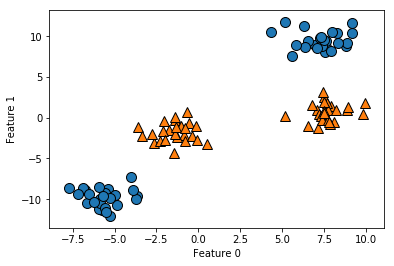

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

* 線形モデルによるクラス分類では、直線で分離することしかできないので、このようなデータセットではうまくいかない



/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feature 1')

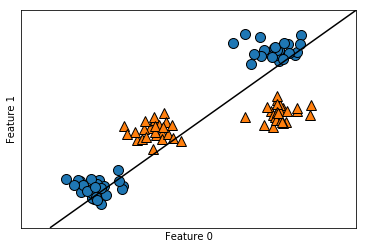

In [3]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

* ここで、入力特徴量を拡張する

    * 例)`feature1 ** 2`(2番目の特徴量の2乗)を新しい特徴量として加える
    
    * データポイントは、`(feature0, feature1, feature1 ** 2)`の三次元の点になる

Text(0.5, 0, 'feature1 ** 2')

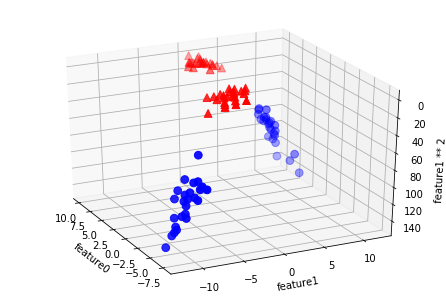

In [4]:
import numpy as np
# 2番目の特徴量の2乗を追加
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# 3Dで可視化
ax = Axes3D(figure, elev=-152, azim=26)

# y == 0の点をプロットしてからy == 1の点をプロット
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

* この表現では、2つのクラスを線形モデルで、つまり3次元空間内の平面を用いて分離することが可能となっている

    * この拡張されたデータセットに対して線形モデルを適用すればわかる

/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'feature1 ** 2')

/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


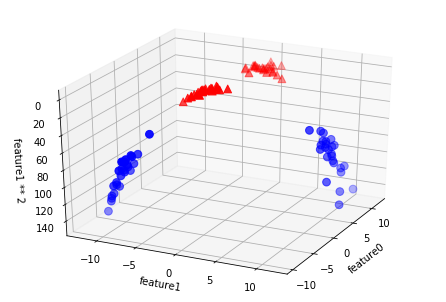

In [6]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 線形決定境界を描画
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] ** YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

Text(0, 0.5, 'Feature 1')

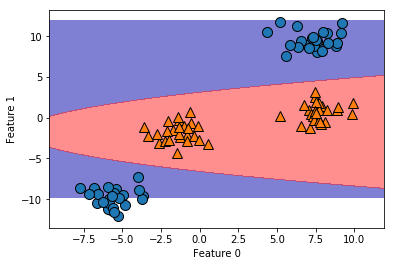

In [8]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## 2. カーネルトリック

* 非線形の特徴量をデータ表現に加えることで、線形モデルがはるかに強力になる

    * 実際は、どの特徴量を加えたら良いかはわからない
    
    * たくさんの特徴量を加えると、計算量が多くなりすぎる
  
* `カーネルトリック`：拡張された特徴表現上でのデータポイント間の距離を、実際にデータポイントの拡張を計算せずに、直接計算する方法

    * 非常に大きくなりうる表現を実際に計算せずに、高次元でのクラス分類器を学習させる
    
* サポートベクタマシンで広く用いられている高次元空間へのマップ方法は以下の2つ

    * `多項式カーネル`：元の特徴量の特定の次数までの全ての多項式(`feature1 ** 2 feature2 ** 5`など)を計算する
    
    * `ガウシアンカーネル`：放射基底関数カーネルとも呼ばれる
    
        * 無限次元の特徴空間に対応する
        
        * 直感的には、全ての次数の全ての多項式を与えるが、次数が高くなるに連れてとの特徴量の重要性を小さくしている
        
* しかし、カーネル法を用いたSVMの背後にある数学の詳細は、実用上重要ではない

    * RBFカーネルを用いたSVMによる決定の様子を見るのは簡単

## 3. SVMを理解する

* 訓練の過程で、SVMは個々のデータポイントが、2つのクラスの決定境界を表現するのにどの程度重要かを学習する

    * 多くの場合、2つのクラスの境界に位置するごく一部の訓練データポイントだけが決定境界を決定する
    
    * これらのデータポイントを、`サポートベクタ`と呼ぶ
    
* 新しいデータポイントに対して予測を行う際に、サポートベクタとデータポイントとの距離が測定される

    * クラス分類は、このサポートベクタの距離と、訓練過程で学習された個々のサポートベクタの重要性(SVCの`dual_coef_`属性に格納)によって決定される
    
* データポイント間の距離は、次のように定義されるがウシアンカーネルで測られる

    * $x_1$、$x_2$：データポイント
    
    * $||x_1 - x_2||$：ユークリッド距離
    
    * $\gamma$：ガウシアンカーネルの幅を制御するパラメータ

\begin{align}
k_{rbf}(x_1, x_2) = exp(-\gamma || x_1 - x_2 ||^2)
\end{align}

* 2次元2クラス分類データセットに対してサポートベクタマシンを学習させた結果を示す

    * 決定境界は黒で書かれており、サポートベクタは大きく縁取りされた点で描かれている
    
    * このプロットを`forge`データセットに対してSVMを訓練して描画するコードを以下に示す

Text(0, 0.5, 'Feature 1')

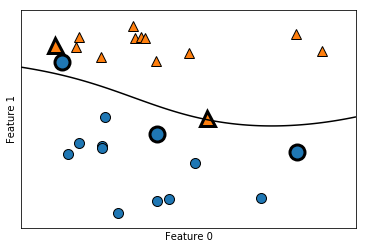

In [9]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# サポートベクタをプロットする
sv = svm.support_vectors_
# サポートベクタのクラスラベルはdual_coef_の正負によって与えられる
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

* この場合、SVMによる境界は非常に滑らかで、非線形(直線ではない)

    * ここでは、`C`と`gamma`の2つのパラメータを調整している

## 4. SVMパラメータの調整

* `gamma`パラメータは、ガウシアンカーネルの幅を調整する

    * このパラメータが、点が近いということを意味するスケールを決定する
    
* `C`パラメータは、線形モデルで用いられたのと同様の正則化パラメータである

    * 個々のデータポイントの重要度(データポイントの`dual_coef_`)を制限する

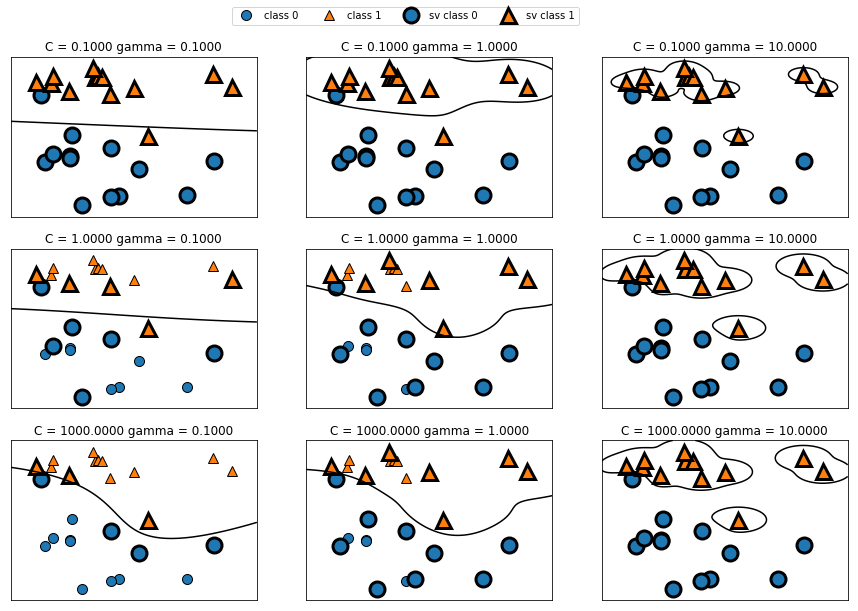

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))

* 左から右へ、パラメータ`gamma`を0.1から10に変化させている

    * `gamma`が小さいと、ガウシアンカーネルの直径が大きくなり、多くの点を近いと判断するようになる
    
    * これによって、左の方では決定曲線が滑らかになり、右に行くに連れて個々のデータポイントをより重視するようになっている
    
    * `gamma`が小さい場合には、決定境界はゆっくりとしか変化せず、モデルの複雑さは小さくなる
    
    * `gamma`が大きくなると、モデルはより複雑になる
    

* 上から下に、パラメータ`C`を0.1から1000に変化させている

    * 線形モデルの場合と同様に、小さい`C`は制限されたモデルに対応し、個々のデータポイントの与える影響は限定される
    
    * 左上の決定境界を見るとほとんど直線であることからもこれがわかる
    
    * クラス分類に失敗したデータポイントもあるが、決定境界には全く影響を与えていない
    
    * `C`を大きくすると、左下のグラフからもわかるように、これらのデータポイントがより強い影響を持つことになり、正しくクラス分類されるように決定境界を曲げている

* RBFカーネル法を用いたSVMを`cancer`データセットに適用する

    * デフォルトパラメータは`C=1`、`gamma=1/n_features`となっている

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


* 訓練セット精度は100%で、テストセット精度は63%ということから、強く過剰適合していることがわかる

    * SVMはうまく動く場合が多いのだが、パラメータの設定とデータのスケールに敏感であるという問題がある
    
    * 特に、全ての特徴量の変位が同じスケールであることを要求する
    
    * 個々の特徴量の最大値と最小値を、対数でプロットしたものを見てみる

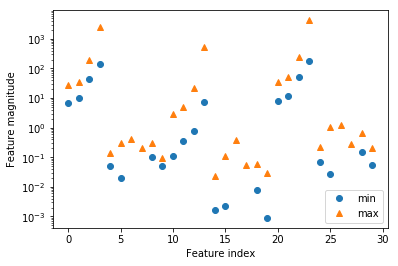

In [16]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

* `cancer`データセットの特徴量は、相互に桁違いにサイズが違うことがわかる

    * これは他のモデル(線形モデルなど)でも問題になるが、カーネル法を用いたSVMでは破壊的な影響をもたらす
    
    * この問題を解決する方法を見てみる

## 5. SVMのためのデータの前処理

* この問題を解決する方法の1つが、全ての特徴量がだいたい同じスケールになるように、それぞれスケール変換する方法である

    * カーネル法を用いたSVMでよく使われる方法は、全ての特徴量が0から1の間になるようにスケール変換する方法
    

In [18]:
# 訓練セットの特徴量ごとに最小値を計算
min_on_training = X_train.min(axis=0)
# 訓練セットの特徴量ごとにレンジ(最大値 - 最小値)を計算
range_on_training = (X_train - min_on_training).max(axis=0)

# 最小値を引いてレンジで割る
# 個々の特徴量はmin=0, max=1となる
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n{}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [19]:
# テストセットに対しても、全く同じ変換を行う
# 訓練セットの最小値とレンジを用いる
X_test_scaled = (X_test - min_on_training) / range_on_training

In [20]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


* データをスケールすると、訓練セット精度とテストセットがだいたい同じで、100%からは遠いという、適合不足の領域に入っている

    * ここから`C`や`gamma`を増やして、複雑なモデルにする

In [21]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


* ここでは`C`を大きくすることで、モデルは大きく改良され、精度が97%となった

## 6. 利点、欠点、パラメータ

* カーネル法を用いたサポートベクタマシン(SVM)は、様々なデータセットに対してうまく機能する強力なモデルである

    * SVMを用いると、データにわずかな特徴量しかない場合にも複雑な決定境界を生成することができる
    
    * 低次元のデータでも高次元のデータでもうまく機能するが、サンプルの個数が大きくなるとうまく機能しない
    
    * SVMは10,000サンプルぐらいまではうまく機能するが、100,000サンプルぐらいになると、実行時やメモリ使用量の面で難しくなってくる
    
* SVMの問題点は、注意深くデータの前処理とパラメータ調整を行う必要があることだ

    * 多くのアプリケーションで勾配ブースティングなどの決定木ベースのモデルの方が用いられている理由
    
    * さらに、SVMのモデルは検証が難しい
    
    * ある予測がされた理由を理解することが難しく、モデルを専門家以外に説明するのも大変である
    
* しかし、特徴量が似た測定器の測定結果(例：カメラのピクセル)のように、同じスケールになる場合には、SVMを試してみる価値がある

* カーネル法を用いたSVMで重要なパラメータは、正則化パラメータ`C`と、カーネルの選択と、カーネル固有のパラメータである
    
    * ここでは、RBFカーネルについて注目したが、scikit-learnにはその他のカーネルも用意されている
    
    * RBFカーネルのパラメータは、ガウシアンカーネルの幅の逆数を表す`gamma`だけである
    
    * `gamma`と`C`は両方ともモデルの複雑さを制御するパラメータで、大きくするとより複雑なモデルになる
    
    * したがって、2つのパラメータの設定は強く相関するため、`C`と`gamma`は同時に調整する必要がある
    

|  版  |    年/月/日    |
|-----|-----------------|
|初版|2019/03/10|